# Load Signals from CSV

You would need Signavio credentials - check if you can access:

https://editor.signavio.com/g/statics/pi/areas

Create *.env* file
```js
MY_SIGNAVIO_PASSWORD=*****
MY_SIGNAVIO_NAME=alexey.streltsov@sap.com

This notebook provides a collection of cells where we load signals from CSV files.
CSV files have been created by extracting Signals from several workspaces by means of Signavio API backend calls.

Here we can run API call to validate Signals against Signavio workspace view. - this step can take 25 mins.

```bash
ls -ltr schemas_from_views_2023-11-28T07_35_58.csv signals_2023-11-28T07_35_58.csv LoadSignalsFromCSV.ipynb
-rw-r--r--@ 1 d071932  staff   573K Nov 28 07:35 schemas_from_views_2023-11-28T07_35_58.csv
-rw-r--r--@ 1 d071932  staff    10M Nov 28 07:35 signals_2023-11-28T07_35_58.csv
-rw-r--r--  1 d071932  staff   1.1M Nov 29 12:31 LoadSignalsFromCSV.ipynb

```


In [1]:
! ls -ltrah schemas_from_views_*.csv signals_*.csv LoadSignalsFromCSV.ipynb

ls: LoadSignalsFromCSV.ipynb: No such file or directory
-rw-r--r--  1 d071211  staff   577K Feb  5 09:35 schemas_from_views_2024-02-01T10_44_03.csv
-rw-r--r--  1 d071211  staff    11M Feb  5 09:35 signals_2024-02-01T10_44_03.csv


In [1]:
import sys
sys.path.append("./")
print(sys.path)

['/Users/d071211/projects/signavio/text2SIGNAL/notebooks', '/Users/d071211/.pyenv/versions/3.11.6/lib/python311.zip', '/Users/d071211/.pyenv/versions/3.11.6/lib/python3.11', '/Users/d071211/.pyenv/versions/3.11.6/lib/python3.11/lib-dynload', '', '/Users/d071211/Library/Caches/pypoetry/virtualenvs/text2signal-_sxAEIlr-py3.11/lib/python3.11/site-packages', '/Users/d071211/projects/signavio/text2SIGNAL', './']


In [2]:
from text2signal.authenticator import initialize_signavio_client, WORKSPACES

auth_clients = {}

for workspace_name, workspace_id in WORKSPACES.items():
    auth_clients[workspace_name] = initialize_signavio_client(workspace_id)



In [4]:
! echo $MY_SIGNAVIO_NAME

darko.velkoski@sap.com


In [3]:
workspace_name = "Process AI"  # or "Solutions Demo Workspace"
signavio_client = auth_clients[workspace_name]

pi_subjects = signavio_client.pi.subjects()
print(pi_subjects)


[PISubject(
    id='demo01-1',
    name='demo01',
    business_area='ba-3',
    currency_code=None,
    preprocessing_status=<PISubjectPreprocessingStatus.PROCESSING_FINISHED: 'PROCESSING_FINISHED'>,
    changed_at=datetime.datetime(2023, 10, 20, 8, 35, 59, 373000, tzinfo=TzInfo(UTC)),
    source_system=None,
    process_types=None,
    event_log_updated_at=datetime.datetime(2023, 10, 20, 8, 35, 57, 484000, tzinfo=TzInfo(UTC)),
    investigation_count=0,
    dashboard_count=0
), PISubject(
    id='dvtest-1',
    name='dv_test',
    business_area='ba-3',
    currency_code=None,
    preprocessing_status=<PISubjectPreprocessingStatus.PROCESSING_FINISHED: 'PROCESSING_FINISHED'>,
    changed_at=datetime.datetime(2023, 11, 9, 17, 14, 55, 609000, tzinfo=TzInfo(UTC)),
    source_system=None,
    process_types=None,
    event_log_updated_at=datetime.datetime(2023, 11, 9, 17, 14, 53, 385000, tzinfo=TzInfo(UTC)),
    investigation_count=1,
    dashboard_count=0
), PISubject(
    id='sfdsdf-1',
  

In [4]:
workspace_name = "Solutions Demo Workspace"
signavio_client = auth_clients[workspace_name]

for process in signavio_client.pi.subjects():
    print(process.id, process.name)
    schema = signavio_client.signal.schema(process.id)
    columns = [field.column_name for field in schema.fields]
    print(columns)

sl-itc-dashboard-test-1 000_DEMO✨ - Dashboards ITC ECC & S4H (DO NOT CHANGE)
['case_id', 'event_name', 'end_time', 'Invoice_u0020_Posting_u0020_Gross_u0020_Amount', 'Event_u0020_Created_u0020_By_u0020_User_u0020_Id', 'Event_u0020_Created_u0020_By_u0020_User_u0020_Type', 'Change_u0020_Old_u0020_Value', 'Change_u0020_New_u0020_Value', 'Changed_u0020_Table', 'Changed_u0020_Field', 'Changed_u0020_Object_u0020_Id', 'Change_u0020_Type', 'Change_u0020_Number', 'Invoice_u0020_Line_u0020_Item', 'Accounting_u0020_Document_u0020_Segment_u0020_Primary_u0020_Key', 'Invoice_u0020_Due_u0020_Date', 'Transaction_u0020_Code', 'Reverse_u0020_Document_u0020_Number', 'Reverse_u0020_Document_u0020_Fiscal_u0020_Year', 'Reversal_u0020_Indicator', 'Document_u0020_Currency', 'Amount_u0020_in_u0020_Document_u0020_Currency', 'Converted_u0020_USD_u0020_Amount', 'Amount_u0020_Eligible_u0020_for_u0020_Cash_u0020_Discount_u0020_in_u0020_Document_u0020_Currency', 'Converted_u0020_USD_u0020_Amount_u0020_Eligible_u0020_

## Example how to run manually -constructed SIGNALS against workspace DB:

In [5]:
def signal_template(signal, view):
    return f'SELECT {signal} FROM "{view}"'

view = "defaultview-529"  
signal = 'AVG((SELECT LAST(end_time) - FIRST(end_time)))'  
constructed_query = signal_template(signal=signal, view=view)

response = signavio_client.signal.query(constructed_query)
print(response.json())

{"header":[{"column_name":"AVG((SELECT LAST(end_time) - FIRST(end_time)))","column_alias":"AVG((SELECT LAST(end_time) - FIRST(end_time)))","column_role":"MEASURE","data_type":"DURATION"}],"data":[[13659129279.096045]]}


# Load CSV Pandas and data Analysis

Here we:
- Load view variables
- Statistical analysis.

In [6]:
# Here we save the above schemas and signals DF to CSV files:
import pandas as pd

filename_schemas="data/temp/schemas_from_views_2024-02-11T23_24_11.csv"
vdf = pd.read_csv(filename_schemas) 

filename_signals="data/temp/signals_2024-02-12T18_02_18.csv"
df = pd.read_csv(filename_signals)

print("Number of unfiltered Signals:",df.shape)
print("Number of vars/views:",vdf.shape)


Number of unfiltered Signals: (9428, 11)
Number of vars/views: (3881, 8)


## Schemas to Data Frames

In [7]:
#vf[["name"]].describe()
vdf[["name","view"]].describe() #.value_counts

,name,view
count,3881,3881
unique,1484,30
top,case_id,defaultview-197
freq,30,250


In [8]:
vdf

,Unnamed: 0,column_name,name,column_role,dataType,view,process,process_id
0,0,case_id,case_id,DIMENSION,TEXT,defaultview-529,000_DEMO✨ - Dashboards ITC ECC & S4H (DO NOT C...,sl-itc-dashboard-test-1
1,1,event_name,event_name,DIMENSION,LIST_TEXT,defaultview-529,000_DEMO✨ - Dashboards ITC ECC & S4H (DO NOT C...,sl-itc-dashboard-test-1
2,2,end_time,end_time,DIMENSION,LIST_TIMESTAMP,defaultview-529,000_DEMO✨ - Dashboards ITC ECC & S4H (DO NOT C...,sl-itc-dashboard-test-1
3,3,Invoice_u0020_Posting_u0020_Gross_u0020_Amount,Invoice Posting Gross Amount,DIMENSION,LIST_NUMBER,defaultview-529,000_DEMO✨ - Dashboards ITC ECC & S4H (DO NOT C...,sl-itc-dashboard-test-1
4,4,Event_u0020_Created_u0020_By_u0020_User_u0020_Id,Event Created By User Id,DIMENSION,LIST_TEXT,defaultview-529,000_DEMO✨ - Dashboards ITC ECC & S4H (DO NOT C...,sl-itc-dashboard-test-1
...,...,...,...,...,...,...,...,...
3876,3876,last_u0020_gr_u0020_shipment_u0020_notice_u002...,Last GR Shipment Notice Reference,DIMENSION,TEXT,defaultview-545,[SIGPIA-2936] Dashboard_PTP_Ariba,sm-ptpariba-1
3877,3877,last_u0020_gr_u0020_supplier_u0020_id,Last GR Supplier Id,DIMENSION,TEXT,defaultview-545,[SIGPIA-2936] Dashboard_PTP_Ariba,sm-ptpariba-1
3878,3878,last_u0020_gr_u0020_supplier_u0020_location_u0...,Last GR Supplier Location Id,DIMENSION,TEXT,defaultview-545,[SIGPIA-2936] Dashboard_PTP_Ariba,sm-ptpariba-1
3879,3879,last_u0020_gr_u0020_item_u0020_processed_u0020...,Last GR Item Processed State,DIMENSION,TEXT,defaultview-545,[SIGPIA-2936] Dashboard_PTP_Ariba,sm-ptpariba-1


In [9]:
# Select columns for given view/TableName
vdf[vdf["view"] == "defaultview-529"]

,Unnamed: 0,column_name,name,column_role,dataType,view,process,process_id
0,0,case_id,case_id,DIMENSION,TEXT,defaultview-529,000_DEMO✨ - Dashboards ITC ECC & S4H (DO NOT C...,sl-itc-dashboard-test-1
1,1,event_name,event_name,DIMENSION,LIST_TEXT,defaultview-529,000_DEMO✨ - Dashboards ITC ECC & S4H (DO NOT C...,sl-itc-dashboard-test-1
2,2,end_time,end_time,DIMENSION,LIST_TIMESTAMP,defaultview-529,000_DEMO✨ - Dashboards ITC ECC & S4H (DO NOT C...,sl-itc-dashboard-test-1
3,3,Invoice_u0020_Posting_u0020_Gross_u0020_Amount,Invoice Posting Gross Amount,DIMENSION,LIST_NUMBER,defaultview-529,000_DEMO✨ - Dashboards ITC ECC & S4H (DO NOT C...,sl-itc-dashboard-test-1
4,4,Event_u0020_Created_u0020_By_u0020_User_u0020_Id,Event Created By User Id,DIMENSION,LIST_TEXT,defaultview-529,000_DEMO✨ - Dashboards ITC ECC & S4H (DO NOT C...,sl-itc-dashboard-test-1
...,...,...,...,...,...,...,...,...
119,119,Last_u0020_Inv_u002e__u0020_Item_u0020_Debit_u...,Last Inv. Item Debit/Credit Indicator Text,DIMENSION,TEXT,defaultview-529,000_DEMO✨ - Dashboards ITC ECC & S4H (DO NOT C...,sl-itc-dashboard-test-1
120,120,Last_u0020_Inv_u002e__u0020_Item_u0020_Tax_u00...,Last Inv. Item Tax Type Text,DIMENSION,TEXT,defaultview-529,000_DEMO✨ - Dashboards ITC ECC & S4H (DO NOT C...,sl-itc-dashboard-test-1
121,121,Inv_u002e__u0020_Cash_u0020_Discount_u0020_Amo...,Inv. Cash Discount Amount in Local Currency,DIMENSION,NUMBER,defaultview-529,000_DEMO✨ - Dashboards ITC ECC & S4H (DO NOT C...,sl-itc-dashboard-test-1
122,122,Inv_u002e__u0020_Cash_u0020_Discount_u0020_Amo...,Inv. Cash Discount Amount in Document Currency,DIMENSION,NUMBER,defaultview-529,000_DEMO✨ - Dashboards ITC ECC & S4H (DO NOT C...,sl-itc-dashboard-test-1


## Transfer Signals read from local files from signals_all_local and extracted from workspaces signals_all to DF

In [10]:
print("Number of Signals:",df.shape)
df.head(3)

Number of Signals: (9428, 11)


,Unnamed: 0,name,query,description,meta,metric_vars,view,signalFragment,process,origin,workspace_name
0,0,Average cycle time,SELECT\n AVG((SELECT LAST(end_time)...,Average cycle time calculated from the first t...,metric,{},defaultview-529,SELECT AVG((SELECT LAST(end_time)) - (SELECT F...,000_DEMO✨ - Dashboards ITC ECC & S4H (DO NOT C...,../data/From_API/Solutions Demo Workspace/000_...,Solutions Demo Workspace
1,1,AVG Cycle Time for Late Payments,SELECT \n\tAVG ((SELECT LAST (END_TIME) FILTER...,Average Cycle Time of all Invoices from Postin...,dashboard,{},defaultview-529,SELECT \n\tAVG ((SELECT LAST (END_TIME) FILTER...,000_DEMO✨ - Dashboards ITC ECC & S4H (DO NOT C...,../data/From_API/Solutions Demo Workspace/000_...,Solutions Demo Workspace
2,2,Rate of Cases executed in a given timeframe,SELECT \n\tCOUNT (CASE_ID) FILTER (\n \tWHE...,Percentage of Cases being executed in a pre-de...,dashboard,{},defaultview-529,SELECT \n\tCOUNT (CASE_ID) FILTER (\n \tWHE...,000_DEMO✨ - Dashboards ITC ECC & S4H (DO NOT C...,../data/From_API/Solutions Demo Workspace/000_...,Solutions Demo Workspace


In [11]:
# DBG
# Check for possible substitution error: ""THIS_PROCESS"" instead "THIS_PROCESS"
df[df['query'].str.contains('THIS_PROCESS')]

,Unnamed: 0,name,query,description,meta,metric_vars,view,signalFragment,process,origin,workspace_name


### Plot duplicates

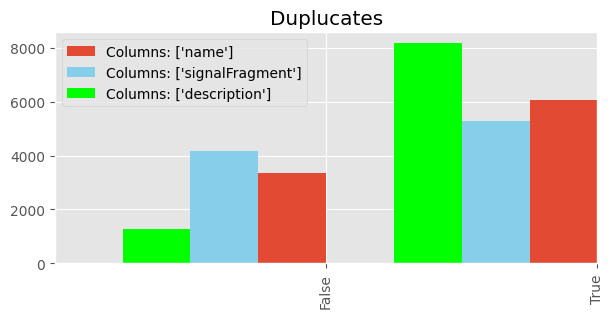

In [12]:
import matplotlib.pyplot as plt
plt.style.use('ggplot') 
# Remove duplicates 
columns= df.columns.to_list() #[0:4] # problem with metrics_vars column
#columns=['name', 'query', 'description', 'meta', 'view', 'signalFragment', 'process', 'origin']
#columns.remove('metric_vars')
#columns=['name', 'query'] #, 'description']
#a= df.duplicated(columns).value_counts()
#columns=['name','signalFragment','description'] 
#columns=['signalFragment'] 
#print(columns)
#b= df.duplicated(columns).value_counts()

width = .25   
columns=['name'] 
title1=f'Columns: {columns}'
df.duplicated(columns).value_counts().sort_index().plot(kind='bar', position=1, width = width, title="Duplucates")
columns=['name','signalFragment'] 
columns=['signalFragment'] 
title2=f'Columns: {columns}'
df.duplicated(columns).value_counts().sort_index().plot(kind='bar', position=2, color='skyblue' , width = width)
columns=['name','signalFragment','description'] 
columns=['description'] 
title3=f'Columns: {columns}'
df.duplicated(columns).value_counts().sort_index().plot(kind='bar',  position=3,  color='lime',  width = width, figsize=(7,3))
plt.legend([title1,title2,title3])
plt.show()

#df.drop_duplicates(columns, keep='first',inplace=True)
#print(columns, df.shape)
#df.value_counts
#df.duplicated(columns).describe()

,name,signalFragment,query,description
count,9428,9428,9428,3975
unique,3358,4154,5419,1268


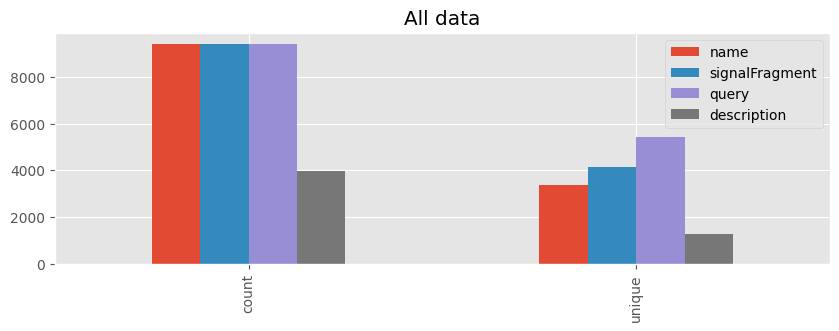

In [13]:
# number of unique records
df[['name','signalFragment','query','description']].describe().loc[['count','unique']].plot(kind='bar', title="All data",figsize=(10,3))
df[['name','signalFragment','query','description']].describe().loc[['count','unique']]

### Add columns with variables extracted from  from queries/signalFragmemts by means of custom SQL parser (sqlglot) and regexp
The extracted results are added as new columns:


#### Here apply lambda with variables extraction (tales 25 secs)

In [14]:
from text2signal.data.signal_validator import extract_query_variables
df = extract_query_variables(df)

SQL parsing error: Expecting ). Line 1, Col: 229.
  e"))   - FIRST (END_TIME) FILTER (      WHERE EVENT_NAME IN ("Post Invoice")))           < DURATION "14days")   / COUNT (CASE_ID) * 100      FROM "defaultview-529" 
SQL parsing error: Invalid expression / Unexpected token. Line 1, Col: 464.
  ultview-529"  WHERE EVENT_NAME MATCHES ("Post Invoice"~>"Clear Invoice") ORDER BY 1 ASC NULLS FIRST FILL timeseries("MONTH")
SQL parsing error: Expecting ). Line 1, Col: 229.
  e"))   - FIRST (END_TIME) FILTER (      WHERE EVENT_NAME IN ("Post Invoice")))           < DURATION "14days")   / COUNT (CASE_ID) * 100      FROM "defaultview-529" 
SQL parsing error: Invalid expression / Unexpected token. Line 1, Col: 568.
  FROM   "defaultview-529" WHERE   EVENT_NAME MATCHES ("Create Invoice") ORDER BY   1 ASC NULLS FIRST FILL TIMESERIES("MONTH"),   NULL
SQL parsing error: Invalid expression / Unexpected token. Line 1, Col: 533.
  pany"  FROM "defaultview-529" WHERE "Inv. Company Code Text" IS NOT NULL O

In [15]:
df[['name','signalFragment','query','description',"parser_column_names","parser_values","parser_error","parser"]].describe().loc[['count','unique']]

,name,signalFragment,query,description,parser_column_names,parser_values,parser_error,parser
count,9428,9428,9428,3975,9428,9428,9428,9428
unique,3358,4154,5419,1268,241,3761,1223,2


In [16]:
df[['parser']].value_counts()

parser  
Signavio    8206
regexp      1222
Name: count, dtype: int64

In [17]:
# get an element
indx=10 #4193
df.loc[[indx]]['signalFragment']
df.loc[[indx]][["workspace_name",'query','parser',"parser_column_names","parser_values"]]
#df[['query',"signalFragment","view","origin"]][indx:indx+1].values.tolist()[0]

,workspace_name,query,parser,parser_column_names,parser_values
10,Solutions Demo Workspace,SELECT \n\tAVG ((SELECT LAST (END_TIME) \n ...,Signavio,"[""END_TIME"", ""EVENT_NAME""]","[""event_name"", ""Clear Invoice"", ""Post Invoice""]"


## Filter out Signals without descriptions and with None descriptions - new data frame:  DF1

With non-null decriptions (3975, 15)
Signals wiht non-empty description (9428, 15)


<Axes: title={'center': 'Siganls with non-empty descriptions'}>

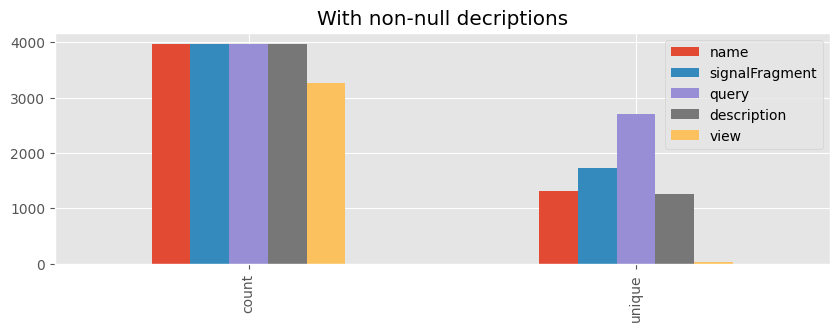

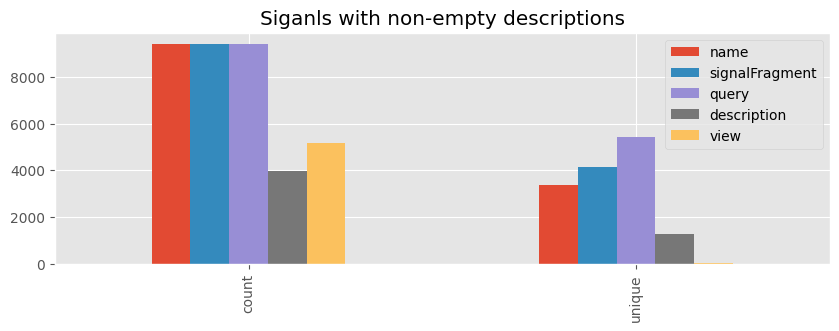

In [93]:
# Filter out Signals without descriptions and with None description
pd.set_option('display.max_colwidth', None)  

new_df = df[~df['description'].isnull()]

print("With non-null decriptions", new_df.shape)
figsize=(10,3)
new_df[['name','signalFragment','query','description','view']].describe().loc[['count','unique']].plot(kind='bar',title="With non-null decriptions",figsize=figsize)

# df1=df[df['description'] != "" ] 

# print("Signals wiht non-empty description",df1.shape)
# figsize=(10,3)
# df1[['name','signalFragment','query','description','view']].describe().loc[['count','unique']].plot(kind='bar',title="Siganls with non-empty descriptions",figsize=figsize)


### Drop duplicates in DF1

In [21]:
# Drop duplicates
df1 = df.copy()

print("Number of Signals before duplicates cleaning:",df1.shape)
columns=['name','description','signalFragment'] 
df1.drop_duplicates(columns, keep='first',inplace=True)
print("Number of unique Signals with not-empty descriptions after duplicate cleaning: ",df1.shape)
df1[['name','description','signalFragment','view']].describe().loc[['count','unique']]


Number of Signals before duplicates cleaning: (9428, 15)
Number of unique Signals with not-empty descriptions after duplicate cleaning:  (4520, 15)


,name,description,signalFragment,view
count,4520,1985,4520,2909
unique,3358,1268,4154,30


In [22]:
df1[['meta']].value_counts()

meta         
metric           1790
dashboard        1514
investigation    1216
Name: count, dtype: int64

## Validate pandas col with signals against log on dataFrame DF1


### Run API Validation here new data frame DFP is used

Number of API calls 4267   duration [mins]: 26.44 mins  0.3760855130297757 per signal call



In [20]:
print("Number of API calls",df1.shape[0],"  duration [mins]:", 0.38*df1.shape[0]/60," View: ",df1.iloc[0]['view'])

Number of API calls 4520   duration [mins]: 28.626666666666665  View:  defaultview-529


In [159]:
from text2signal.data.signal_validator import validate_and_update_queries_with_views
# possible_views = df['view'].dropna().unique().tolist()
# dfp = update_queries_with_views(dfp,possible_views, signavio_client)
possible_views = ['defaultview-320']
dfp = validate_and_update_queries_with_views(df1.copy(), possible_views, signavio_client)


{"details":{"name":"BD payment terms"},"errorType":"ColumnNotFound","message":"ColumnNotFound: 'BD payment terms'"}
Error: 422 Client Error: Unprocessable Entity for url: https://editor.signavio.com/g/api/pi-graphql/signal
{"details":{"name":"Process Flow"},"errorType":"ColumnNotFound","message":"ColumnNotFound: 'Process Flow'"}
Error: 422 Client Error: Unprocessable Entity for url: https://editor.signavio.com/g/api/pi-graphql/signal
{"details":{"name":"Inv. Region"},"errorType":"ColumnNotFound","message":"ColumnNotFound: 'Inv. Region'"}
Error: 422 Client Error: Unprocessable Entity for url: https://editor.signavio.com/g/api/pi-graphql/signal
{"details":{"name":"SD Distribution Channel Text"},"errorType":"ColumnNotFound","message":"ColumnNotFound: 'SD Distribution Channel Text'"}
Error: 422 Client Error: Unprocessable Entity for url: https://editor.signavio.com/g/api/pi-graphql/signal
{"details":{"name":"Inv. Region"},"errorType":"ColumnNotFound","message":"ColumnNotFound: 'Inv. Region

## Here we WRITE/READ data frames with validated queries to CSV 

In [161]:
#%%script echo skipping
# Here we save the above schemas and signals DF to CSV files:
from pathlib import Path
import datetime

# valid_pdf = dfp[(dfp['APIvalidated'] == "ok")  & (dfp['validationDataLength'] >= 1) & (dfp['validationDataResponse'] != '[[null]]') & (dfp['validationDataResponse'] != '[[0.0]]')] 
valid_pdf = dfp[(dfp['APIvalidated'] == "ok")  & (dfp['validationDataLength'] >= 1) & (dfp['validationDataResponse'] != '[[null]]')] 

date_str = datetime.datetime.now().strftime("%Y-%m-%dT%H_%M_%S")
filepath_validated = Path(f'data/temp/subset_validated_{valid_pdf.shape[0]}_signals_{date_str}.csv')  

# WRITE
filepath_validated.parent.mkdir(parents=True, exist_ok=True)  
valid_pdf.to_csv(filepath_validated)  
print(f"WRITE CSV file with Validated Signals: {filepath_validated} shape {valid_pdf.shape}")




WRITE CSV file with Validated Signals: data/temp/subset_validated_2772_signals_2024-02-12T23_30_55.csv shape (2772, 18)
